# Starter code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
from sklearn.preprocessing import normalize as norm
from sklearn import linear_model
import datetime
import time
from datetime import datetime , timedelta
import seaborn as sns;
import zipfile
import math
#from tensorflow.keras.optimizers import Adam
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from keras.layers import GRU
#from keras.layers import ReLU
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import mean_squared_error

#% matplotlib inline

#import plotly.offline as py
#import plotly.figure_factory as ff
#import plotly.graph_objs as go
from csv import reader
from matplotlib.pyplot import figure

#py.init_notebook_mode(connected=True)

#py_config = {'displayModeBar': False, 'showLink': False, 'editable': False}

#from ipywidgets import interact, interactive, fixed, interact_manual, widgets

In [2]:
#list_of_companies_number = ['1080']
#list_of_companies_number = ['13113']

list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [3]:
len(list_of_companies_number)

99

In [4]:
help_time = []

In [5]:
#shape = [(nr of company, every possible timeslot from 8.01 till 16.30, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,5)) 
#data =  np.zeros(shape = (100, 5100,3)) 

In [6]:
def get_k_best_offers(record, k=5):
    count = 0
    count_bid = 0
    count_ask = 0
    five_best_bids_and_asks = np.zeros(shape = (2,2,5))
    while(record[count]!='ASK'):
        count+=1
    for counter in range(1,k*2 + 1):
        #bid
        if record[count-counter]=='BID':
            continue
        five_best_bids_and_asks[0][counter%2][(counter-1)//2]=record[count-counter]
        #ask
        five_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=record[count+counter]
        
    return five_best_bids_and_asks

In [7]:
def calc_semi_var(elements):
    mean = np.mean(elements)
    semi_var = 0
    for i in elements:
        if i<mean:
            semi_var += (mean-i)**2
    return semi_var

In [8]:
def get_mid_price(record): #shape = (2,2,5) (bid/ask, price/volume, best offers):
    return (record[1][0][0]+record[0][0][0])/2

In [9]:
def get_true_price(record): # Qa*Pb/(Qa+Qb) + Qb*Pa/(Qa+Qb)
    Qa=record[1][1][0] #ask quantity
    Qb=record[0][1][0] #bid quantity
    Q=Qa+Qb
    Pa=record[1][0][0] #ask price
    Pb=record[0][0][0] #bid price
    return Qa*Pb/(Q+1e-10) + Qb*Pa/(Q+1e-10)

In [10]:
def get_sweep_to_fill_price(record, order_size, midprice, sweep_buy=False):
    if sweep_buy:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            #print("Unable to fill an order")
            return midprice
    return weighted_price/order_size

In [11]:
def apply_moving_average(record, num_of_days_prev):
    for i in range(num_of_days_prev, record.shape[0]):
        record[i] = np.sum(record[i-num_of_days_prev+1:i+1])/num_of_days_prev
    return record

In [12]:
def index_to_time(index):
    hour=index//60
    minute=index%60
    return hour+8, minute+1, 0


In [13]:
def get_true_price_after_sweep_to_fill(record, order_size, midprice):
    curr_record = record
    order_left = order_size
    counter=0
    while order_left>0:
        curr_vol = curr_record[1][1][counter]
        if curr_vol >= order_left:
            curr_record[1][1][counter]-=order_left
            order_left =0
            counter-=1
        else:
            curr_record[1][1][counter] = 0
            order_left-=curr_vol
        counter+=1
        if counter==5:
            #print("Unable to fill an order", order_size)
            return midprice
    Qa=0 #ask quantity
    Qb=0 #bid quantity
    Pa=0 #ask price
    Pb=0 #bid price
    row_in_queue = 0
    while curr_record[1][1][row_in_queue]==0:
        row_in_queue+=1
    Qa=curr_record[1][1][row_in_queue]
    Pa=curr_record[1][0][row_in_queue]
    row_in_queue = 0
    while curr_record[0][1][row_in_queue]==0:
        row_in_queue+=1
    Qb=curr_record[0][1][row_in_queue] 
    Q=Qa+Qb 
    Pb=curr_record[0][0][row_in_queue] 
    return Qa*Pb/Q + Qb*Pa/Q

In [140]:
def get_vwap_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True, max_vol=math.inf):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    vwaps=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #vwaps_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    for day in range(vwaps.shape[0]):
        trade_counter=0
        for counter in range(vwaps.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])
            time_tuple=index_to_time(interval*(counter+1))
            buys=[]
            sells=[]
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys.append(trades_time_comp[day][trade_counter][0])
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells.append(trades_time_comp[day][trade_counter][0])
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
                vwaps[day,2*counter]=buys_avg-true_price
            except:
                buys_avg=true_price
                buys_vol=0
                empty_buys+=1
                vwaps[day,2*counter]=math.nan
            try:
                sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
                if use_abs:
                    vwaps[day,2*counter +1]=true_price-sells_avg
                else:
                    vwaps[day,2*counter +1]=sells_avg-true_price 
            except:
                sells_avg=true_price
                sells_vol=0
                empty_sells+=1
                vwaps[day,2*counter +1]=math.nan
            if sells_vol>max_vol:
                sells_vol=math.nan
            if buys_vol>max_vol:
                buys_vol=math.nan 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    return vwaps, order_sizes

In [142]:
def get_s2f_impact_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    s2f_impacts=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #s2f_impacts_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    for day in range(s2f_impacts.shape[0]):
        trade_counter=0
        for counter in range(s2f_impacts.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])   # true price at start of the intertval, as in pdf
            time_tuple=index_to_time(interval*(counter+1))
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_vol=np.sum(buys_weights)
                # when buying we sweep asks
                buys_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], buys_vol, true_price, sweep_buys=False)  # order book at start of the intertval, as in pdf
                s2f_impacts[day,2*counter]=buys_s2f_price-true_price
            except ValueError:
                buys_s2f_price=true_price
                buys_vol=0
                empty_buys+=1
                s2f_impacts[day,2*counter]=math.nan
            try:
                sells_vol=np.sum(sells_weights)
                # when selling we sweep buys
                sells_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], sells_vol, true_price, sweep_buys=True)
                if use_abs:
                    s2f_impacts[day,2*counter +1]=true_price-sells_s2f_price
                else:
                    s2f_impacts[day,2*counter +1]=sells_s2f_price-true_price 
            except ValueError:
                sells_s2f_price=true_price
                sells_vol=0
                empty_sells+=1
                s2f_impacts[day,2*counter +1]=math.nan
         #   if sells_vol>10000 or buys_vol>10000: #discard super high volumes,
          #      continue 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    return s2f_impacts, order_sizes

In [143]:
def get_next_trade_x_comp(comp_id=3, interval=5, time_to_skip=0, get_x='price'):

    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time
    timestamps=(510-time_to_skip)//interval
        
    next_trade_x=np.empty(shape=(10,timestamps))
    for day in range(time_to_next_trade.shape[0]):
        trade_counter=0
        start_time=index_to_time(0+time_to_skip)
        while start_time>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for book_counter in range(timestamps):            
            time_tuple=index_to_time(book_counter*interval)
            while time_tuple>=trades_time_comp[day][trade_counter][2]:
                trade_counter+=1
            if get_x=='price':
                next_trade_price=trades_time_comp[day][trade_counter][0]
                next_trade_x[day, book_counter]=next_trade_price
            elif get_x=='size':
                next_trade_size=trades_time_comp[day][trade_counter][1]
                next_trade_x[day, book_counter]=next_trade_size                
            elif get_x=='time':
                trade_time_tuple=trades_time_comp[day][trade_counter][2]
                next_trade_x[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])-timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
            # time to next trade given in seconds
            else:
                raise ValueError
    return next_trade_x

In [14]:
## prices on the start of interval
def get_true_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    true_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            true_price_comp[i]=get_true_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return true_price_comp
def get_mid_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    mid_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            mid_price_comp[i]=get_mid_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return mid_price_comp

In [135]:
data[0][:5100].shape

(5100, 2, 2, 5)

In [136]:
def get_order_inbalance(comp_id, interval = 5, period = 5100, time_to_skip = 0): #single company
    record = data[comp_id][:period]
    timestamps=record.shape[0]//interval
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)
    return result

In [133]:
def get_price_change_comp(comp_id=1, interval=1, time_to_skip=0, use_true_price=True): #interval in minutes
    if use_true_price:
        prices=np.asarray([get_true_price(data[comp_id][i]) for i in range (5100)])
    else:
        prices=np.asarray([get_mid_price(data[comp_id][i]) for i in range (5100)])
    
    timestamps=(510-time_to_skip)//interval
    price_diff=np.empty(shape=(10,timestamps))
    for i in range(10):
        for t in range(timestamps-1):
            pom=i*510 + time_to_skip + t
            price_diff[i,j]=prices[pom]-prices[pom+interval]
    return price_diff

In [162]:
def get_trading_volume_and_price_volatility(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (8*60+30-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    open_hour = 8
    open_min = 0
    end_hour = 16
    end_min = 30
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 10000000.0
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            trade_hour = trade_time[0]
            trade_min = trade_time[1]
            if (trade_hour<open_hour) or (trade_hour==open_hour and trade_min<open_min) or (trade_hour==end_hour and trade_min>end_min) or trade_hour>end_hour:
                continue
            which_bucket = ((trade_hour-open_hour)*60 + (trade_min-open_min))//interval
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [152]:
trades[0].shape[0]

10

Reading data from files

In [17]:
# open file in read mode
mom_count = 0
count_comp = -1
for num_comp in list_of_companies_number:
    with open('FTSE100\OrderBookSnapshots.csv.'+num_comp+'\OrderBookSnapshots.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        count = 0
        count_comp+=1
        prev_hour = 8
        prev_date = '20130902'
        prev_min=0
        prev_elements = []
        for row in csv_reader:
            elements = row[0].split('\t')
            date_time = elements[0]
            date_holder, time_holder = date_time.split(' ')
            if date_holder != prev_date:
                prev_hour = 8
                prev_min=0
            cur_hour = int(time_holder[:2])
            cur_min = int(time_holder[2:4])
            if((cur_hour==8 and cur_min>0) or (cur_hour>8 and cur_hour<16) or (cur_hour==16 and cur_min<=30)):
                data[count_comp][count] = get_k_best_offers(elements[1:])  
                count+=1

In [18]:
# open file in read mode
days={
    2:0,
    3:1,
    4:2,
    5:3,
    6:4,
    9:5,
    10:6,
    11:7,
    12:8,
    13:9,
}
if_first_row = True
which_comp = 0

#comp = list_of_companies_number
comp = list_of_companies_number
comp_id = -1
trades = np.empty( shape=(len(comp), 10), dtype = list)
for i in range(trades.shape[0]):
    for j in range(10):
        trades[i,j]=list()
for num_comp in comp:
    comp_id+=1
    if_first_row = True
    with open('FTSE100trades\TradeDetailsExtract.'+num_comp+'.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        for row in csv_reader:
            if if_first_row:
                if_first_row = False
                continue
            date = row[4]
            date_elem = date.split(" ")
            act_day = int(date_elem[0][8:10])
            time_tuple=time.strptime(date_elem[1], '%H:%M:%S')
            time_tuple=(time_tuple.tm_hour, time_tuple.tm_min, time_tuple.tm_sec)
          #  trades=np.append(trades, (row[2], row[3], time_tuple),  axis=1)
            #print("XD", comp_id, act_day, date_elem, row[2], row[3], time_tuple)
            try:
                trades[comp_id][days[act_day]].append((float(row[2]), int(row[3]), time_tuple)) # price, volume, timestamp
            except:
                print("Bad acting day or data, please check both\n", comp_id, act_day)
                print((row[2]), (row[3]), time_tuple)

Bad acting day or data, please check both
 1 30
854.5066 4596 (7, 5, 24)
Bad acting day or data, please check both
 1 8
900.0 4848 (0, 0, 0)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 3 30
841.9143 11354 (7, 5, 24)
Bad acting day or data, please check both
 5 30
389.3276 3223 (7, 5, 24)
Bad acting day or data, please check both
 7 30
435.4457 4675 (7, 5, 24)
Bad acting day or data, please check both
 9 30
2146.5318 1115 (7, 5, 24)
Bad acting day or data, please check both
 12 30
290.7493 3328 (7, 5, 24)
Bad acting day or data, please check both
 13 30
120.01 100 (7, 5, 24)
Bad acting day or data, please check both
 16 30
1103.1111 414 (7, 5, 24)
Bad acting day or data, please check both
 17 30
1090.5 25000 (17, 37, 50)
Bad acting day or data, please check both
 20 30
761.5762 127

Bad acting day or data, please check both
 97 30
345.1342 1168 (7, 5, 24)
Bad acting day or data, please check both
 98 30
1596.4102 231 (7, 5, 24)


In [19]:
def sweep_to_fill_costs_ex_1(list_of_comp, order_sizes, cut_first_minutes_to_plot = 0):
    nr_of_comp = len(list_of_comp)
    average_fill_prices = np.zeros(shape = (99, 510, 6))
    mid_prices = np.zeros(shape = (99,510))
    for comp_id in list_of_comp: 
        comp_id = int(comp_id)
        bid_and_ask_through_day = data[comp_id]
        for i in range(5100):
            mid_prices[comp_id][i%510] += get_mid_price(bid_and_ask_through_day[i])
            curr_mid_price =  get_mid_price(bid_and_ask_through_day[i])
            for j in range(6):
                average_fill_prices[comp_id][i%510][j] += get_sweep_to_fill_price(bid_and_ask_through_day[i], order_sizes[j],curr_mid_price)
        for i in range(510):
            mid_prices[comp_id][i]/=10
            average_fill_prices[comp_id][i]/=10
        mid_prices[comp_id] = apply_moving_average(np.copy(mid_prices[comp_id]), 5)
        for i in range(6):
            average_fill_prices[comp_id][:,i] = apply_moving_average(np.copy(average_fill_prices[comp_id][:,i]), 5)
    return average_fill_prices, mid_prices

In [20]:
def get_s2f_impact_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    s2f_impacts=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #s2f_impacts_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    for day in range(s2f_impacts.shape[0]):
        trade_counter=0
        for counter in range(s2f_impacts.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])   # true price at start of the intertval, as in pdf
            time_tuple=index_to_time(interval*(counter+1))
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_vol=np.sum(buys_weights)
                # when buying we sweep asks
                buys_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], buys_vol, true_price, sweep_buys=False)  # order book at start of the intertval, as in pdf
                s2f_impacts[day,2*counter]=buys_s2f_price-true_price
            except ValueError:
                buys_s2f_price=true_price
                buys_vol=0
                empty_buys+=1
                s2f_impacts[day,2*counter]=math.nan
            try:
                sells_vol=np.sum(sells_weights)
                # when selling we sweep buys
                sells_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], sells_vol, true_price, sweep_buys=True)
                if use_abs:
                    s2f_impacts[day,2*counter +1]=true_price-sells_s2f_price
                else:
                    s2f_impacts[day,2*counter +1]=sells_s2f_price-true_price 
            except ValueError:
                sells_s2f_price=true_price
                sells_vol=0
                empty_sells+=1
                s2f_impacts[day,2*counter +1]=math.nan
         #   if sells_vol>10000 or buys_vol>10000: #discard super high volumes,
          #      continue 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    return s2f_impacts, order_sizes

In [21]:
def get_sweep_to_fill_price_raising_error(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if order_size==0:
        raise ValueError("Order size is 0")
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            raise ValueError("Unable to fill an order of size " + str(order_size))
    return weighted_price/order_size

In [22]:
len([3])

1

In [117]:
def get_s2f_impact_and_ordersizes_comp_for_interval(comps_id=[3], interval=5, time_to_skip=0, minute=40, use_abs=True):
    order_book_comp=np.empty(shape=(len(comps_id),10, interval, 2, 2, 5))
    which_bucket = minute//interval
    s2f_impacts=np.zeros(shape=(len(comps_id),10,2)) 
    order_sizes=np.zeros(shape=(len(comps_id),10,2))
    for j in range(len(comps_id)):
        for i in range(10): #we have data from 10 days, 2 work weeks
            order_book_comp[j][i]=data[comps_id[j]][510*i+minute:510*i+minute+interval]
    for comp_id in range(len(comps_id)):
        trades_time_comp=np.copy(trades[comps_id[comp_id]])
        for day in trades_time_comp:
            day.sort(key=lambda hour: hour[2]) # sort by trade time

        # buys on even, sells on odd
        #s2f_impacts_sells=np.zeros(shape=(10,timestamps))
        empty_sells=0
        empty_buys=0
        for day in range(s2f_impacts.shape[1]):
            trade_counter=0
            true_price=get_true_price(order_book_comp[comp_id,day,0])   # true price at start of the intertval, as in pdf
            time_tuple_next=index_to_time(minute+interval)
            time_tuple_curr=index_to_time(minute)
            buys_weights=[]
            sells_weights=[]
            while time_tuple_curr>trades_time_comp[day][trade_counter][2]:
                trade_counter+=1
            while time_tuple_next>trades_time_comp[day][trade_counter][2]:
                #print(day)
                #print(trades_time_comp[day][trade_counter])
                #print(order_book_comp[comp_id][day][0])
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_vol=np.sum(buys_weights)
                # when buying we sweep asks
                buys_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[comp_id,day,0], buys_vol, true_price, sweep_buys=False)  # order book at start of the intertval, as in pdf
                s2f_impacts[comp_id,day,0]=buys_s2f_price-true_price
            except ValueError:
                #print("XD")
                buys_s2f_price=true_price
                buys_vol=0
                empty_buys+=1
                s2f_impacts[comp_id,day,0]=math.nan
            try:
                sells_vol=np.sum(sells_weights)
                # when selling we sweep buys
                sells_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[comp_id,day,0], sells_vol, true_price, sweep_buys=True)
                if use_abs:
                    s2f_impacts[comp_id,day,1]=true_price-sells_s2f_price
                else:
                    s2f_impacts[comp_id,day,1]=sells_s2f_price-true_price 
            except ValueError:
                #print("XD")
                sells_s2f_price=true_price
                sells_vol=0
                empty_sells+=1
                s2f_impacts[comp_id,day,1]=math.nan
            order_sizes[comp_id,day,0]=buys_vol
            order_sizes[comp_id,day,1]=sells_vol
        #print(sells_vol)
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2)))    
    return s2f_impacts, order_sizes

In [122]:
companies = np.arange(99)
companies

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98])

20.0% of intervals were SELL empty
15.0% of intervals were BUY empty
[[4261.    0.]
 [   0. 5138.]
 [ 171.  829.]
 [   0.   47.]
 [ 996. 1232.]
 [5665.  136.]
 [1913.  100.]
 [1010.    0.]
 [   0.    0.]
 [1258.  846.]]
(1980,)


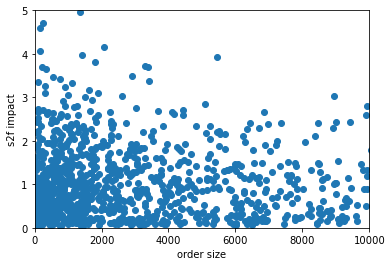

In [126]:
company_id=[3]
interval=5
time_to_skip=0

s2f_impacts, order_sizes_s2f=get_s2f_impact_and_ordersizes_comp_for_interval(comps_id = companies, interval = interval, minute = 40)
#vwaps, order_sizes_vwaps=get_vwap_and_ordersizes_comp(company_id, interval, time_to_skip, max_vol=np.max(order_sizes_s2f.flatten()))
s2f_impacts
print(order_sizes_s2f[0])
plt.axes(xlabel='order size', ylabel='s2f impact')
plt.scatter(order_sizes_s2f.flatten(), s2f_impacts.flatten())
plt.xlim(0,  10000)
plt.ylim(0,5)
plt.show()

In [127]:
for i in range(99):
    curr_
s2f_impacts.shape

(99, 10, 2)

In [128]:
xd = np.zeros(99)

# Plot of sweep to fill costs of company nr 1080 (Exhibit 1)

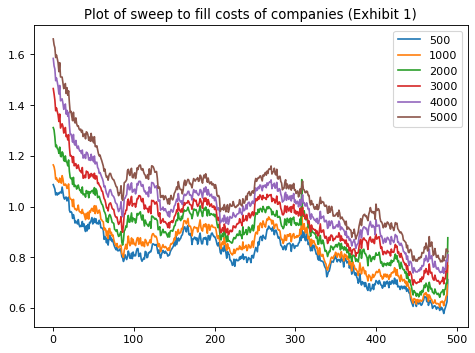

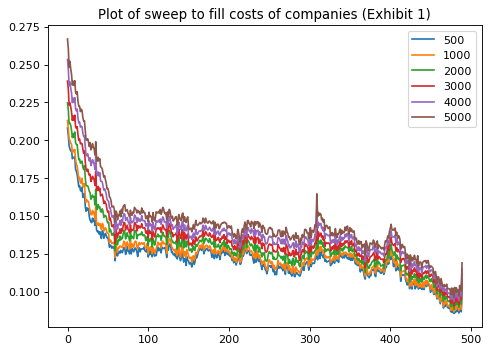

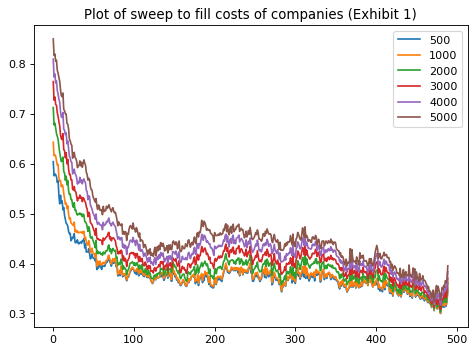

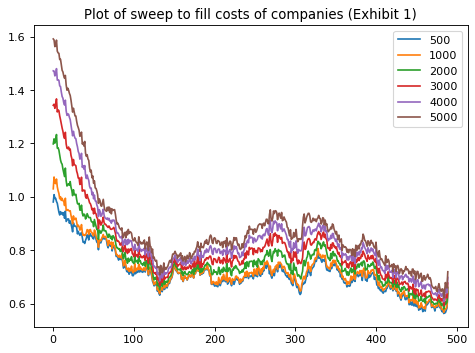

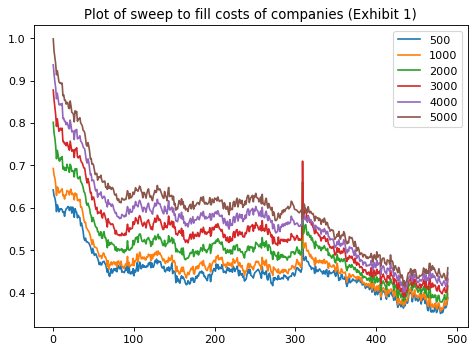

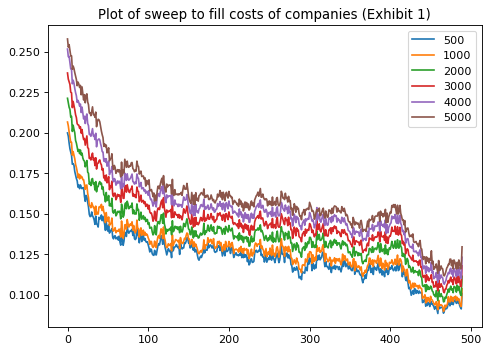

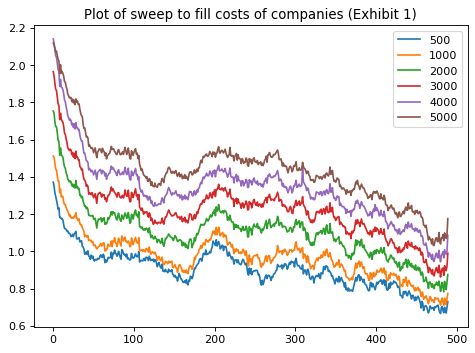

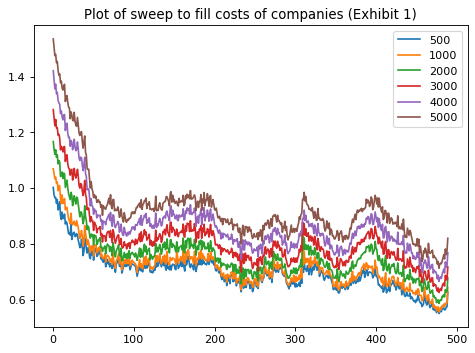

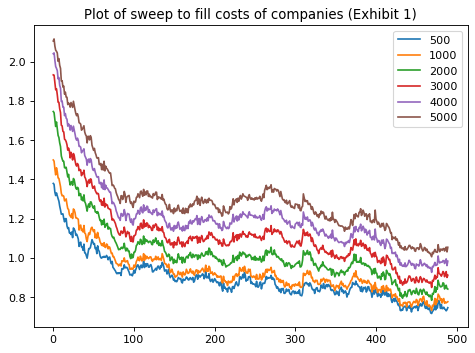

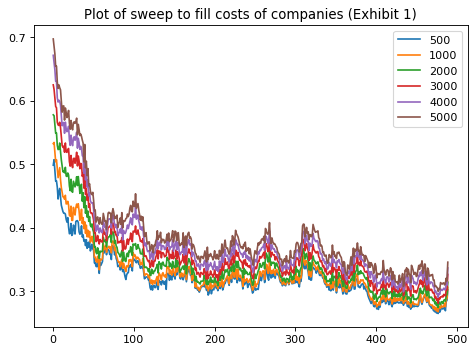

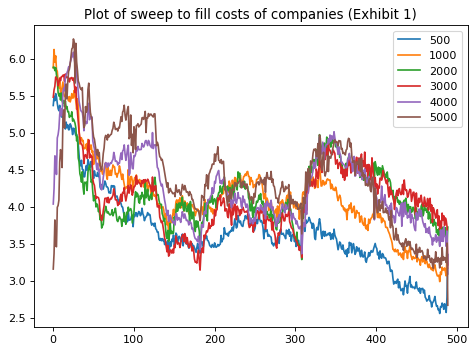

In [155]:
order_sizes = [500, 1000, 2000, 3000, 4000, 5000]
list_of_test_comps = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
cut_first_minutes_to_plot = 20
average_fill_prices, mid_prices = sweep_to_fill_costs_ex_1(list_of_test_comps, order_sizes, cut_first_minutes_to_plot)
for j in list_of_test_comps:
    figure(figsize=(7, 5), dpi=80)
    for i in np.arange(len(order_sizes)):
        plt.plot(np.arange(510- cut_first_minutes_to_plot), average_fill_prices[j][cut_first_minutes_to_plot:,i]-mid_prices[j][cut_first_minutes_to_plot:])
    plt.legend( order_sizes)
    plt.title("Plot of sweep to fill costs of companies (Exhibit 1)")

In [156]:
order_inbalance_one_day=get_order_inbalance(data[0][:510])

Plotting Bid, ask and true market prices(exhibit 6)

In [157]:
mid_price_one_day=np.zeros(510)
true_price_one_day=np.zeros(510)

for i in range (0,510):
    mid_price_one_day[i]=get_mid_price(data[0][i])
    true_price_one_day[i]=get_true_price(data[0][i])

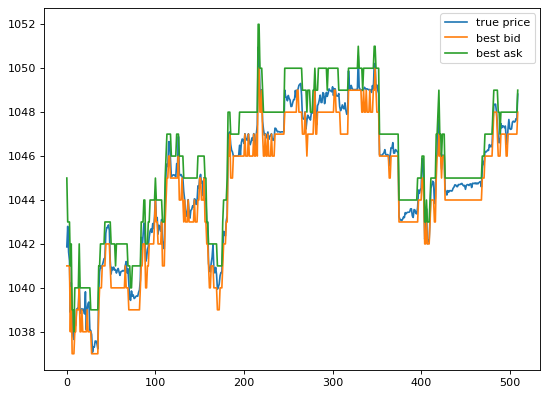

In [158]:
figure(figsize=(8, 6), dpi=80)

#plt.plot(np.arange(510), order_inbalance_one_day)#, mid_price_one_day)

#plt.plot(np.arange(510),  mid_price_one_day)
plt.plot(np.arange(510),  true_price_one_day)
plt.plot(np.arange(510),  data[0,:510,0,0,0])
plt.plot(np.arange(510),  data[0,:510,1,0,0])
plt.legend(['true price', 'best bid', 'best ask'])

Plotting Sweep to Fill Costs vs Order Size (exhibit 8 and 9)?????

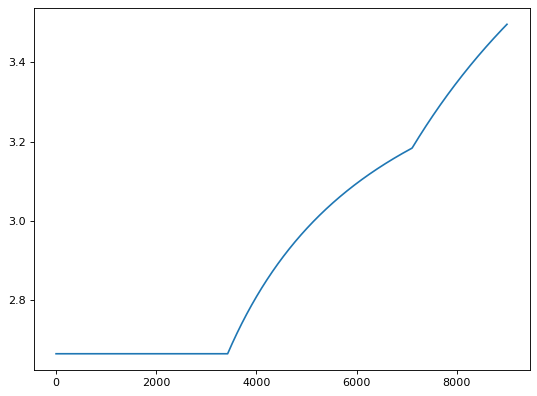

In [159]:
figure(figsize=(8, 6), dpi=80)
#bid_and_ask_through_first_two_hours = data[80][:120]
order_sizes_limit = 9000
true_price = get_true_price(data[80][40])
average_fill_prices = np.zeros(shape = (order_sizes_limit))
for i in range(1,order_sizes_limit+1):
    average_fill_prices[i-1] = get_sweep_to_fill_price(data[80][40], i,true_price)
plt.plot(average_fill_prices-true_price)

In [160]:
data[80][40]

array([[[1640., 1639., 1638., 1637., 1636.],
        [1715., 5727., 2576., 2830., 5163.]],

       [[1644., 1645., 1646., 1647., 1648.],
        [3425., 3681., 4334., 2581., 4997.]]])

In [161]:
order_inbalance_10_days=get_order_inbalance(data[1])
mid_price_10_days=[get_mid_price(data[1][i]) for i in range (0, 5100)]

In [162]:
company=19
order_inbalance_10_days=[round(i, 1) for i in get_order_inbalance(data[company])]
mid_price_10_days=np.asarray([get_mid_price(data[company][i]) for i in range (5100)])
price_diff=mid_price_10_days[:5099]-mid_price_10_days[1:]
inbalance_averageprice={}
for i in range(len(price_diff)):
    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    else:
        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
for k in inbalance_averageprice.keys():
    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

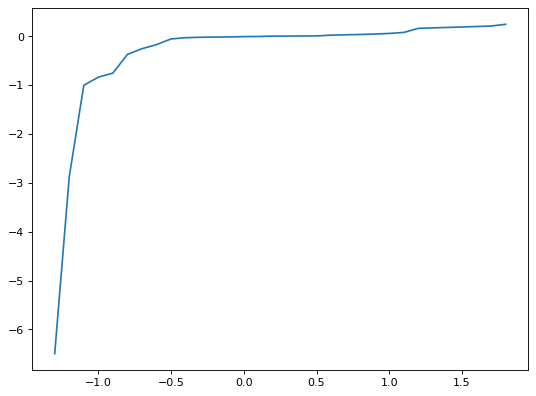

In [163]:
inbalance_averageprice_array=np.sort( np.asarray([[k, v] for k,v in inbalance_averageprice.items()]), axis=0)
figure(figsize=(8, 6), dpi=80)

plt.plot(inbalance_averageprice_array[:,0], inbalance_averageprice_array[:,1])


Exhibit 17 -> Market impact for E-mini S&P Futures on a Typical Day (how to calculate true price after market impact???)

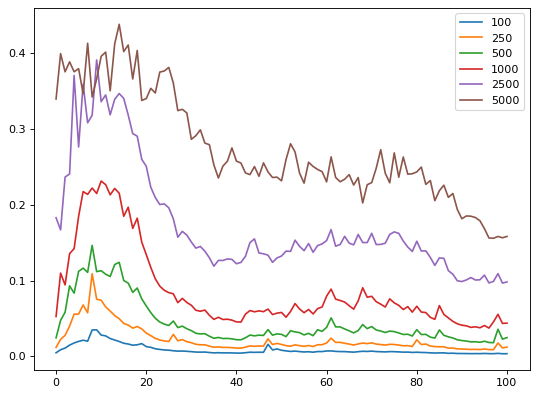

In [164]:
company_id = 15
order_sizes = [100, 250, 500, 1000, 2500, 5000]
num_of_timestamps = int((5100/5)-1)
modulo = int(510/5-1)
differences_in_prices = np.zeros(shape = (modulo, 6))
for i in range(num_of_timestamps):
    for order_size_ind in range(len(order_sizes)):
        price_before = get_true_price(np.copy(data[company_id][i*5]))
        price_after = get_true_price_after_sweep_to_fill(np.copy(data[company_id][i*5]), order_sizes[order_size_ind], price_before)
        differences_in_prices[i%modulo][order_size_ind] += abs(price_after - price_before)
figure(figsize=(8, 6), dpi=80)
for i in range(modulo):
    differences_in_prices[i]/=10
for k in range(len(order_sizes)):
    plt.plot(np.arange(modulo), apply_moving_average(np.copy(differences_in_prices[:,k]), 3))
plt.legend( order_sizes)
    

# Exhibit 3&4


In [165]:
comp_id=0
order_book_comp=np.empty(shape=(10, 510, 2, 2, 5))
order_inbalance_comp=np.empty(shape=order_book_comp.shape[:2])
for i in range(10): #we have data from 10 days, 2 work weeks
    order_book_comp[i]=data[comp_id, 510*i:510*(i+1)]
    order_inbalance_comp[i]=get_order_inbalance(order_book_comp[i])

trades_time_comp=np.copy(trades[comp_id])
for day in trades_time_comp:
    day.sort(key=lambda hour: hour[2]) # sort by trade time
time_to_next_trade=np.empty(shape=order_inbalance_comp.shape)

In [166]:
time_to_next_trade.shape

(10, 510)

In [167]:
trades[0].shape

(10,)

In [168]:
for day in range(time_to_next_trade.shape[0]):
    trade_counter=0
    for book_counter in range(time_to_next_trade.shape[1]):
        #print("XD", book_counter)
        time_tuple=index_to_time(book_counter)
        while time_tuple>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        trade_time_tuple=trades_time_comp[day][trade_counter][2]
        time_to_next_trade[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])-timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
        # time to next trade given in seconds


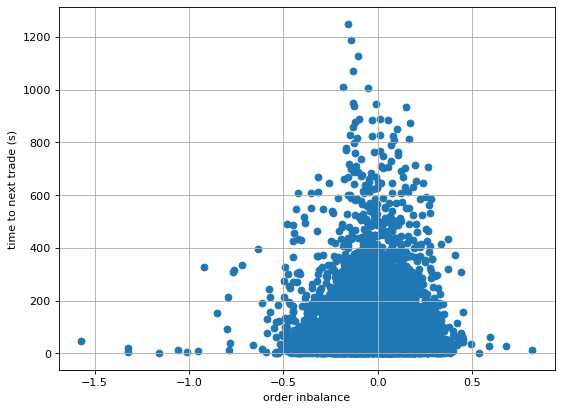

In [169]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='order inbalance', ylabel='time to next trade (s)')
plt.scatter(order_inbalance_comp.flatten(), time_to_next_trade.flatten())
plt.grid()
plt.show()

In [170]:
next_trades_prices=np.empty(shape=order_inbalance_comp.shape)
for day in range(time_to_next_trade.shape[0]):
    trade_counter=0
    for book_counter in range(time_to_next_trade.shape[1]):
        time_tuple=index_to_time(book_counter)
        while time_tuple>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        next_trade_price=trades_time_comp[day][trade_counter][0]
        next_trades_prices[day, book_counter]=next_trade_price
        # time to next trade given in seconds

In [171]:
mid_market_prices=np.empty(shape=order_inbalance_comp.shape)
for day in range(order_book_comp.shape[0]):
    for record in range(order_book_comp.shape[1]):
        mid_market_prices[day, record]=get_mid_price(order_book_comp[day, record])

In [172]:
for day in range(mid_market_prices.shape[0]):
    for record in range(mid_market_prices.shape[1]):
        if mid_market_prices[day,record]==0:
            print(day, record)

9 509


In [173]:
(np.arange(10))[:-1]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

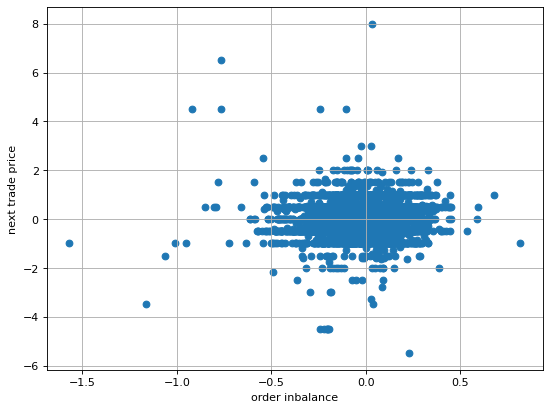

In [174]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='order inbalance', ylabel='next trade price')
plt.scatter(order_inbalance_comp[:-1].flatten(), (next_trades_prices-mid_market_prices)[:-1].flatten())
plt.grid()
plt.show()

# Exhibit 11&12


In [175]:
interval=5
comp_id=0
order_book_comp=np.empty(shape=(10, 510, 2, 2, 5))
for i in range(10): #we have data from 10 days, 2 work weeks
    order_book_comp[i]=data[comp_id, 510*i:510*(i+1)]

trades_time_comp=np.copy(trades[comp_id])
for day in trades_time_comp:
    day.sort(key=lambda hour: hour[2]) # sort by trade time

timestamps=510//interval
vwaps=np.zeros(shape=(10,2*timestamps))
order_sizes=np.zeros(shape=(10,2*timestamps))
#vwaps_sells=np.zeros(shape=(10,timestamps))
#order_sizes_sells=np.zeros(shape=(10,timestamps))



In [176]:
empty_orders=0
for day in range(vwaps.shape[0]):
    trade_counter=0
    for counter in range(vwaps.shape[1]//2):
        true_price=get_true_price(order_book_comp[day,counter])
        time_tuple=index_to_time(interval*(counter+1))
        buys=[]
        sells=[]
        buys_weights=[]
        sells_weights=[]
        while time_tuple>trades_time_comp[day][trade_counter][2]:
            if true_price<trades_time_comp[day][trade_counter][0]:
                buys.append(trades_time_comp[day][trade_counter][0])
                buys_weights.append(trades_time_comp[day][trade_counter][1])
            else:
                sells.append(trades_time_comp[day][trade_counter][0])
                sells_weights.append(trades_time_comp[day][trade_counter][1])               
            trade_counter+=1
            
        # in case there were no sells or buys during the interval            
        try:
            buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
        except:
            buys_avg=true_price
            buys_vol=0
            empty_orders+=1
        try:
            sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
        except:
            sells_avg=true_price
            sells_vol=0
            empty_orders+=1
        if sells_vol>10000 or buys_vol>10000:
            continue 
        vwaps[day,2*counter]=buys_avg-true_price
        vwaps[day,2*counter +1]=true_price-sells_avg
        order_sizes[day,2*counter]=buys_vol
        order_sizes[day,2*counter +1]=sells_vol
print('{}% of intervals were empty'.format(100*empty_orders/(10*2*timestamps)))

50.78431372549019% of intervals were empty


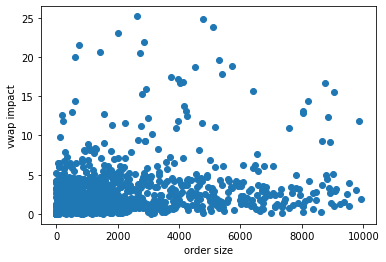

In [177]:
plt.axes(xlabel='order size', ylabel='vwap impact')
plt.scatter(order_sizes.flatten(), vwaps.flatten())

In [178]:
np.unique(order_sizes, return_counts=True)[1][0]

1164

In [179]:
np.unique(vwaps, return_counts=True)[1][0]

1164

In [180]:
vwaps[0].shape

(204,)

**Exhibit 15 & 16**

In [181]:
difference_in_volumes_and_volatilities = np.empty( shape=(len(list_of_companies_number),2), dtype = list)
trading_volumes_and_volatilities = np.empty( shape=(len(list_of_companies_number),2), dtype = list)
for i in range(trading_volumes_and_volatilities.shape[0]):
    for j in range(2):
        trading_volumes_and_volatilities[i,j]=list()
        difference_in_volumes_and_volatilities[i,j]=list()

In [182]:
interval = 5
time_to_skip = 0
len_array=(8*60+30-time_to_skip)//interval + 1
trading_volumes_and_volatilities=np.zeros(shape=(len(list_of_companies_number),2,len_array))
difference_in_volumes_and_volatilities = np.zeros(shape=(len(list_of_companies_number),2,len_array-2))
for i in range(len(list_of_companies_number)):
    vol, vola = get_trading_volume_and_price_volatility(i, interval, time_to_skip)
    trading_volumes_and_volatilities[i][0] = vol
    trading_volumes_and_volatilities[i][1] = vola

In [183]:
for i in range(len(list_of_companies_number)):
    vols = trading_volumes_and_volatilities[i][0]
    rolled_vols = np.roll(np.asarray(vols), 1)
    changes_in_volumes = vols-rolled_vols
    difference_in_volumes_and_volatilities[i][0] = changes_in_volumes[1:-1]
    volas = trading_volumes_and_volatilities[i][1]
    rolled_volas = np.roll(np.asarray(volas), 1)
    changes_in_volatilities = volas-rolled_volas
    difference_in_volumes_and_volatilities[i][1] = changes_in_volatilities[1:-1]

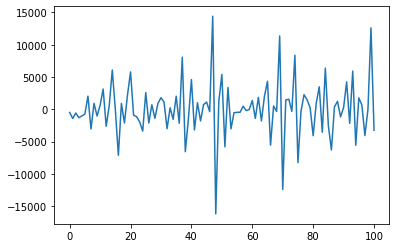

In [184]:
plt.plot(difference_in_volumes_and_volatilities[0][0])

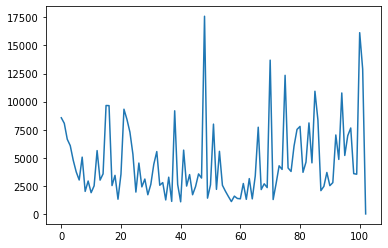

In [185]:
plt.plot(trading_volumes_and_volatilities[0][0])

In [186]:
volumes_of_trades = difference_in_volumes_and_volatilities[:,0,:]
price_volatilities_of_trades = difference_in_volumes_and_volatilities[:,1,:]

In [187]:
volumes_of_trades.shape

(99, 101)

In [188]:
volumes_df = pd.DataFrame(volumes_of_trades)
price_vol_df = pd.DataFrame(price_volatilities_of_trades)

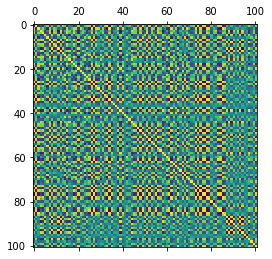

In [189]:
plt.matshow(volumes_df.corr())

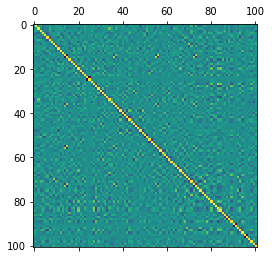

In [190]:
plt.matshow(price_vol_df.corr())

In [191]:
corrs_classic= 0
corrs_abs = 0
for i in range(99):
    corrs_abs+=np.abs(np.corrcoef(volumes_of_trades[i], price_volatilities_of_trades[i])[1][0])
    corrs_classic += np.corrcoef(volumes_of_trades[i], price_volatilities_of_trades[i])[1][0]
print("Average correlation:",corrs_classic/99)
print("Average correlation with abs: ",corrs_abs/99)

Average correlation: 0.1638718843043289
Average correlation with abs:  0.18683913610720138


20.0% of intervals were SELL empty
15.0% of intervals were BUY empty


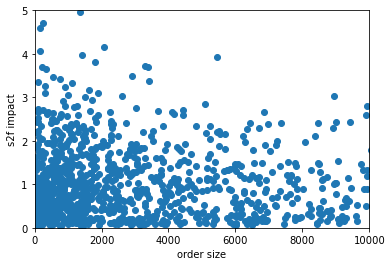

In [131]:
company_id=[49]
interval=5
time_to_skip=0

s2f_impacts, order_sizes_s2f=get_s2f_impact_and_ordersizes_comp_for_interval(comps_id = companies)
#vwaps, order_sizes_vwaps=get_vwap_and_ordersizes_comp(company_id, interval, time_to_skip, max_vol=np.max(order_sizes_s2f.flatten()))

plt.axes(xlabel='order size', ylabel='s2f impact')
plt.scatter(order_sizes_s2f.flatten(), s2f_impacts.flatten())
plt.xlim(0,  10000)
plt.ylim(0,5)
plt.show()



## Heatmapa ##

In [132]:
comp_id = 0

In [166]:
#mid_price, true_price, order_size, order_impact, order_inbalance, vwap, s2fill_impact, s2fvwap, price_volatility, next_trade_price, time2next_trade, trading_volume
mid_price = get_mid_price_comp(comp_id = comp_id, interval = 5)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id = comp_id, interval = 5)
print(true_price.shape)
order_inbalance = get_order_inbalance(comp_id = comp_id, interval = 5)
order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id = comp_id, interval = 5) 
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id = comp_id, interval = 5) 
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(company_id = 0)
print(trading_volumes.shape)
print(price_volatilities.shape)

(10, 102)
(10, 102)
(10, 102)
34.754901960784316% of intervals were SELL empty
16.029411764705884% of intervals were BUY empty
(10, 102)
(10, 102)
35.294117647058826% of intervals were SELL empty
17.107843137254903% of intervals were BUY empty
(10, 102)
(10, 102)
(10, 102)
(10, 102)
(10, 102)
(10, 102)


In [180]:
xdd = mid_price.flatten()

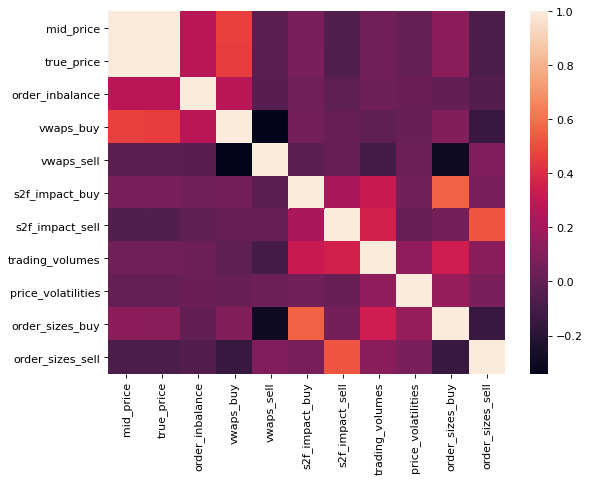

In [194]:
df = pd.DataFrame({'mid_price': mid_price.flatten(), 'true_price': true_price.flatten(), 'order_inbalance': order_inbalance.flatten(), 
                    'vwaps_buy': vwaps_buy.flatten(), 'vwaps_sell': vwaps_sell.flatten(), 's2f_impact_buy': s2f_impact_buy.flatten(), 
                     's2f_impact_sell': s2f_impact_sell.flatten(), 'trading_volumes': trading_volumes.flatten(), 'price_volatilities': price_volatilities.flatten(),
                    'order_sizes_buy': order_sizes_buy.flatten(), 'order_sizes_sell': order_sizes_sell.flatten()})

figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr())
plt.show()

In [196]:
df

,mid_price,true_price,order_inbalance,vwaps_buy,vwaps_sell,s2f_impact_buy,s2f_impact_sell,trading_volumes,price_volatilities,order_sizes_buy,order_sizes_sell
0,1047.5,1047.548794,-0.210740,0.133882,0.999333,3.133882,NaN,6623.0,3.0000,721.0,0.0
1,1047.5,1047.548794,0.588221,NaN,4.422260,NaN,NaN,5011.0,4.0000,0.0,0.0
2,1047.5,1047.548794,0.089977,NaN,2.048121,NaN,1.253732,2948.0,1.0000,0.0,2602.0
3,1047.5,1047.548794,-0.027031,NaN,2.554225,NaN,0.880223,2642.0,2.0000,0.0,1954.0
4,1047.5,1047.548794,0.279865,1.076520,NaN,2.117927,NaN,2083.0,1.0000,2083.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1015,1075.5,1075.757446,-0.011444,NaN,3.868098,NaN,1.708865,14166.0,0.8737,0.0,13237.0
1016,1075.5,1075.757446,-0.073240,NaN,4.190961,NaN,0.690961,3.0,0.0000,0.0,2.0
1017,1075.5,1075.757446,0.062487,NaN,4.165085,NaN,0.665085,2.0,0.0000,0.0,2.0
1018,1075.5,1075.757446,0.087340,NaN,3.929778,NaN,0.611011,92.0,0.5000,0.0,322.0
